#  Packages

### Downloading packages 
#### Select and run just either one of them

In [ ]:
!pip install --upgrade pip
!pip install pandas
!pip install seaborn --force
!pip install matplotlib

### Importing libraries

In [52]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

### Reading files and setting variables

In [53]:
path, file, extension = '../../data/', 'Results for 141', '.csv'
df = pd.read_csv (os.path.join(path, file) + extension, sep = ',')

# ETL

### Renaming a column and changing axis order

In [54]:
df.insert(loc = 1, column = 'Overall Score', value = df['Overall'])
df.drop(['Overall'], axis=1, inplace=True)

### Reindexing columns

In [55]:
df = df.reindex(columns=[
    'Employee', 'Overall Score', 'EC2 (2)', 
    'S3 Arch (0.5)', 'S3 Access (0.5)', 'S3 Classes (0.5)', 'S3 DR (0.5)', 'IAM (1)', 'Networking (2)', 'Net. App. Reliability (2)', 
    'Configuration drift', 'Count and ForEach', 'Environment', 'Organizing resources', 'Process', 'Secrets and States', 'Sensitive information', 'TF Best practices', 'Values to terraform', 
    'Architecture: Auto Scaling', 'Architecture: Control Plane', 'Core Concepts', 'Services & Networking: Ingress', 'Services & Networking: Service', 'Workload Management'
])

### Re-group of columns for better management

In [56]:
df.columns = [
    '[Candidate] ID', '[Candidate] Overall',
    '[AWS] EC2', '[AWS] S3: Arch', '[AWS] S3: Access', '[AWS] S3: Clasess', '[AWS] S3: DR', '[AWS] IAM', '[AWS] Networking', '[AWS] Net. App. Reliability',
    '[TF] Configuration drifts', '[TF] Use of count & for_each', '[TF] Environments', '[TF] Managing resources', '[TF] Process', '[TF] Secrets and States', '[TF] Sensitive information', '[TF] Best practices', '[TF] Managing values', 
    '[K8] Architecture: Auto Scaling', '[K8] Architecture: Control Plane', '[K8] Core Concepts', '[K8] Services & Networking: Ingress', '[K8] Services & Networking: Service', '[K8] Workload Management'
]

### Adding hired/no hired labels

In [57]:
df['Hired'] = ['Yes' if x >= 50 else 'No' for x in df['[Candidate] Overall']]
df.insert(loc = 1, column = '[Candidate] Hired', value = df['Hired'])
df.drop(['Hired'], axis=1, inplace=True)

# Functions definitions

### Disclaimer

In [50]:
'''
Most of these functions have been taken from the 'EDA_Attrition_Dataset.ipynb' file, so all coding credits go to the respective author.
'''

"\nMost of these functions have been taken from the 'EDA_Attrition_Dataset.ipynb' file, so all coding credits go to the respective author.\n"

### Generate pie chart

In [68]:
def generate_pie_chart(df, feature, name):
    # Detecting quantities of each class
    label_yes = sum(df[feature] == "Yes")
    label_no  = sum(df[feature] == "No")

    # Defining labels
    size_of_groups = [label_no, label_yes]
    names          = ["No {}" .format(name), "{}" .format(name)]

    # Generating outer cirle plot
    plt.figure(figsize=(5, 5))
    plt.title("Number of observations per class of the {} variable" .format (name))
    plt.pie(size_of_groups, labels=names)

    # Adding a circle at the center to create the pie
    my_circle = plt.Circle((0,0), 0.7, color='white')
    p         = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

### 

# EDA

### Functions executions

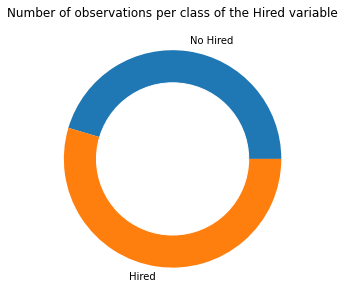

In [69]:
generate_pie_chart (df, '[Candidate] Hired', 'Hired')
